# Descarta de datos
Actualmente se estan descargando los datos del satelite **Sentinel-2**

Faltantes en el codigo:
- Descargar 2 imagenes, la imagen completa satlital correspondiendte a la zona de interés, quiero una imagen ligeramente más grande que el área de interes. 
- Hacer el filtro de nubosidad solo para el área de interés 

**DATOS DE INTERES**

In [1]:
years =[2023] # Para simplificar el proceso ahora solo integraremos un año  
months = [1,3,5,7,9,10,11]  

**IMPORTACION DE LIBRERIAS**

In [2]:
import os
import ee 
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import geemap
import pandas as pd


In [3]:
current_date = datetime.date.today()

# Extraremos el año y mes 
current_year= current_date.year
current_month = current_date.month
print("Mes actual:", current_month)
print("Año actual:", current_year)

Mes actual: 12
Año actual: 2024


## Autentificación para GCP 

In [4]:
# 1) Obtención de la dirección de trabajo 
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave 
service_account= direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación 
credentials = ee.ServiceAccountCredentials(email=None,key_file=service_account)
ee.Initialize(credentials)

## 1) Importación del área de interés 
**NOTA:** Se obtiene el área de interés por medio de un archivo tipo Geojson, kml o shape. Para este ejemplo se utilizará un KML. 

### 1.1) Carga y visualización con geopandas

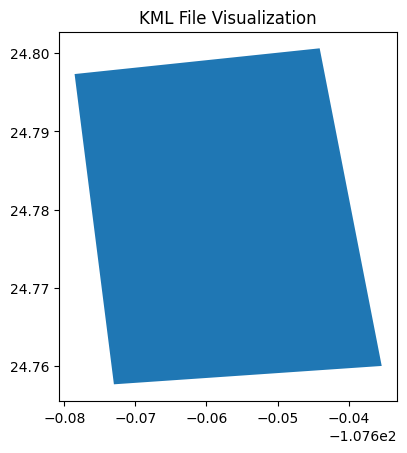

In [5]:
# Direction of the KML 
kml_file = direction + "/data/01_raw/Agricultura.kml"

# Nombre del archivo GeoJson a exportar 
geojson_file = direction + "/data/01_raw/Agricultura.geojson"

# 1) Lectura del kml 
gdf = gpd.read_file(filename=kml_file, driver="KML")

# 2) Exportación del kml a un Geo JSON 
gdf.to_file(filename=geojson_file, driver="GeoJSON")

# Plot using Geopandas
gdf.plot()

# Customize the plot
plt.title("KML File Visualization")
plt.show()

## 2) Descarga de imagenes satelitales
En esta sección se abordarán los siguientes procesos 

- **[Creación de un geometria para Earth Engine](https://developers.google.com/earth-engine/apidocs/ee-geometry)**: La geometria de earth engine se puede crear a partir de un GeoJSON, esto serivara para hacer el corte en las imagenes satelitales de interés
  
- Descarga de datos satelitales para esa área junto con un filtro al área de intrés, fechas y nubosidad 

### 2.1) Creación de una geometría de earth engine 
Para la creación de una geometría lo más indicado es convertir el KML en un archivo GeoJSON y este leerlo directamtne como geometría 

In [6]:
import json
# Step 1: Load the GeoJSON file

with open(geojson_file, "r") as f:
    geojson_data = json.load(f)

geojson_data["features"][0]["geometry"] # IMPORTANTE: Vease como contiene una tercera coordenada que es la altura (los valores de 0) , se deben de retirar 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008, 0.0],
   [-107.6353327971003, 24.76000824378666, 0.0],
   [-107.6440665193485, 24.80059938041618, 0.0],
   [-107.6785631858739, 24.79730942750482, 0.0],
   [-107.6730266244965, 24.75766085153008, 0.0]]]}

**Eliminación de la coordinada de elevación**

In [7]:
# Step 2: Function to remove the third dimension
def remove_third_dimension(geometry):
    """Removes the third dimension (z-values) from GeoJSON coordinates."""
    if geometry["type"] == "Polygon":
        geometry["coordinates"] = [
            [[coord[0], coord[1]] for coord in ring] for ring in geometry["coordinates"]
        ]
    elif geometry["type"] == "MultiPolygon":
        geometry["coordinates"] = [
            [[[coord[0], coord[1]] for coord in ring] for ring in polygon]
            for polygon in geometry["coordinates"]
        ]
    elif geometry["type"] == "LineString":
        geometry["coordinates"] = [[coord[0], coord[1]] for coord in geometry["coordinates"]]
    elif geometry["type"] == "Point":
        geometry["coordinates"] = geometry["coordinates"][:2]
    return geometry

# Step 3: Clean the geometry, ejecucón de la funcion 
cleaned_geometry = remove_third_dimension(geojson_data["features"][0]["geometry"])
cleaned_geometry # Vease ocmo aqui ya estan retirados la tercera dimensión de la altura 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008],
   [-107.6353327971003, 24.76000824378666],
   [-107.6440665193485, 24.80059938041618],
   [-107.6785631858739, 24.79730942750482],
   [-107.6730266244965, 24.75766085153008]]]}

**Convertir en geometría de Earth Engine**

In [8]:
# Step 4: Convert to Earth Engine Geometry
area_interest = ee.Geometry(cleaned_geometry)
type(area_interest)

ee.geometry.Geometry

### 2.2) Creación de un mapa base e integración de área de interés

**AÑADIMOS LA GEOMETRIA AL MAPA**

In [9]:
# 1) Creación del mapa base 
Map  = geemap.Map()

# Anadimos un base map distinto 
Map.add_basemap(basemap="Esri.WorldImagery")  # Imagene satelital de ESRI 

# 2) Add the geometry to the map
Map.addLayer(area_interest, {"color": "red"}, "Cleaned Geometry")

# Center the map on the geometry
Map.centerObject(area_interest, 11)

### 2.3) Descarga de imagenes satelitales

**IMPORTANTE:** Se hará la descarga de las imagenes en los años que se eligieron al inicio 

In [11]:
# Definición del diccionario de imágenes
image_dic = {}  # Lista vacía

for i in years:
    for z in months:
        
        # Condicionante para pasar meses futuros
        if i <= current_year and z <= current_month:
            
            # 1) Importación del image collection de Copernicus
            sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")
            
            # 2) Filtro por área de interés
            sentinel2 = sentinel2.filterBounds(geometry=area_interest)
            
            # 3) Filtro por fechas de interés
            sentinel2 = sentinel2.filterDate(start=f"{i}-{z}-01", end=f"{i}-{z}-28")  # año, mes y día
            
            # 4) Filtro por nubosidad
            sentinel2 = sentinel2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # nubosidad menor al 20%
            # NOTE: This is still a image collection object 
           
            # NOTA IMPORTANTE: Este filtro de nubosidad es bueno, pero es para toda la imagen satelital, qué pasa si mi área de interpres no tiene nubes?, debo determinar el área de nubosidad exactamente sobre mi área de interes 
            
            # 5) Select the first cloud-free image de ese mes de ese año que cumpla con el filtro
            image = sentinel2.first()
            
            # 6) Recorte de la imagen
            if image.getInfo() is not None:  # Validar que la imagen no sea null
                
                # *elección de bandas visibles y banda 8 (infra rojo cercano) 
                image = image.select(['B2', 'B3', 'B4', 'B8'])
                
                # Recorte de la imagen usando la función de clip de ee
                image = image.clip(area_interest)  # Recorta al área de interés
                                
                # 7) Almacenar en el diccionario
                image_dic[f"{i}-{z}"] = image
                print(f"Solicitud de descarga en la fecha: {i}-{z}")
            else:
                print(f"No se encontró ninguna imagen válida para {i}-{z}")

Solicitud de descarga en la fecha: 2023-1
Solicitud de descarga en la fecha: 2023-3
Solicitud de descarga en la fecha: 2023-5
Solicitud de descarga en la fecha: 2023-7
Solicitud de descarga en la fecha: 2023-9
Solicitud de descarga en la fecha: 2023-10
Solicitud de descarga en la fecha: 2023-11


**PENDIENTE:** Hay que meter un filtro de nubosidad más estricto, que evaluemos la cantidad de nubes pero SOLO en la zona de interés. 

In [32]:
## ES LO QUE ME PUSO EL CHAT PARA EL FILTRADO DE NUBES EN EL AREA DE INTERES 

#def cloud_percentage_in_aoi(image, aoi):
 #   """Calculate cloud percentage within the area of interest (AOI)."""
    # Mask clouds using QA60 band (1 = clouds, 0 = clear)
  #  cloud_mask = image.select('QA60').eq(1)
    
    # Calculate the total number of pixels in the AOI
   # total_pixels = ee.Number(image.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))

    # Calculate cloud pixels in the AOI
   # cloud_pixels = ee.Number(cloud_mask.clip(aoi).reduceRegion(
    #    reducer=ee.Reducer.count(),
     #   geometry=aoi,
      #  scale=10,
       # maxPixels=1e13
   # ).values().get(0))
    
    # Calculate cloud percentage
   # cloud_percentage = cloud_pixels.divide(total_pixels).multiply(100)
   # return cloud_percentage

# Main script
#image_dic = {}  # Dictionary to store images

#for i in years:
 #   for z in months:
  #      if i <= current_year and z <= current_month:
            # 1) Import Sentinel-2 image collection
   #         sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    #            .filterBounds(area_interest) \
     #           .filterDate(f"{i}-{z}-01", f"{i}-{z}-28") \
      #          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # Rough initial filter
            
            # 2) Filter images based on AOI-specific cloud percentage
       #     def filter_by_aoi_cloud(image):
        #        cloud_percent = cloud_percentage_in_aoi(image, area_interest)
         #       return image.set('CLOUD_PERCENT_AOI', cloud_percent)
            
            # Apply AOI-specific cloud percentage calculation
          #  images_with_cloud_info = sentinel2.map(filter_by_aoi_cloud)

            # Filter images where AOI cloud coverage is less than 10%
  #          filtered_images = images_with_cloud_info.filter(ee.Filter.lt('CLOUD_PERCENT_AOI', 10))
            
            # Select the first image
   #         image = filtered_images.first()
            
            # Check if image exists and process
    #        if image.getInfo() is not None:
                # Select visible bands and band 8
     #           image = image.select(['B2', 'B3', 'B4', 'B8'])
      #          image = image.clip(area_interest)
                
                # Store the image
       #         image_dic[f"{i}-{z}"] = image
        #        print(f"Image for {i}-{z} meets cloud criteria in AOI.")
         #   else:
          #      print(f"No valid image found for {i}-{z}.")


In [33]:
image # Vease que en los metadatos de la imagenes solo se muestran 4 imagenes 

## 3) Exportación 
La exportación la realizaremos a un bucket de GCP
 
API Reference: https://developers.google.com/earth-engine/apidocs/export-image-tocloudstorage#colab-python

**NOTA IMPORTANTE:** La exportación de las imagenes debe de cumplir ciertos requerimientos para que earth engine pueda aceder a ellos, los cuales son: 

It must be located in the US multi-region or US-CENTRAL1 region.

### 3.1) Exportación de imagenes

In [12]:
# 1) Obtención de las llaves del diccionario
keys = list(image_dic.keys())
images_names =[]

# Inicio del ciclo 
for i in keys: 
    
    # 1) Lectura de los datos 
    image = image_dic[i]
    
    task = ee.batch.Export.image.toCloudStorage(
    image=image,
    #description=f"Export", # Este es el nombre del archivo que se exportara , si vas a usar el filenameprexi no es necesario esto 
    bucket='earth_engine_selene',  # Cambia esto al nombre de tu bucket
    region = area_interest,
    fileNamePrefix=f"sentinel2/image_{i}", # Damos una dirección dentro del bucket y le damos nombre 
    scale=10,  # Resolución en metros
    fileFormat='GeoTIFF')  # Formato de archivo
    
    task.start()  # Inicia la tarea de exportación
    print("Se exportó la imagen a Cloud Storage:", i)    
    
    # Image name
    name = f"image_{i}"
    images_names.append(name)

Se exportó la imagen: 2023-1
Se exportó la imagen: 2023-3
Se exportó la imagen: 2023-5
Se exportó la imagen: 2023-7
Se exportó la imagen: 2023-9
Se exportó la imagen: 2023-10
Se exportó la imagen: 2023-11


### 3.2) Exportación de mapa html 
Este mapa contiene las capas agregadas, en este caso solo el área de interés 

In [34]:
# Visualizacion del mapa en un broswer 
html_file = direction + "/data/02_intermediate/Map.html" # String de la direccion de exportacion
Map.to_html(filename=html_file, title="My Map", width="100%", height="880px") # Exporacion a una html 
# NOTA : En estos momentos solo agrege el area de interes, no estan las imagenes TIF 

### 3.3) Exportación del nombre de las imagenes 
Esto lo utilizaremos pasa saber exactamente que es lo que se exporto al bucket 

In [20]:
# 1) Creación del pandas DF 
names = pd.DataFrame(data=images_names, columns=["Images names"])

# 2) Exportación a csv 
names.to_csv(path_or_buf=direction + "/data/02_intermediate/images_names.csv", index=False)